## DGCCA for EHR dataset

There are several ways to run DGCCA in EHR dataset:

1. Use each patient data as an example. Use diagnosis, procedure and medication as three different views of the tensor. See if people with similar diagnosis cluster?

2. Use diagnosis vs procedure view. Each diagnosis is an example. Each procedure is a feature. 

3. Use diagnosis vs medication view.
    

In [ ]:
Available model: dgcca_ehr_diag_med_fed_1

In [8]:
import 

NameError: name '_C' is not defined

In [ ]:
ehr_dataset = EhrDataset(data_file='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_med_frequent',
                         shuffle=True)

In [2]:
import torch

In [55]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from dgcca.utils.run_manager import RunBuilder
from dgcca.models import g_step, DeepGCCA
import pprint as pp
from dgcca.utils.compressor import qsgd
from dgcca.ehr.dataset_ehr import EhrDataset

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import random
import numpy as np

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest', default='trained_models/dgcca_ehr_cutemaxvar1.model', help="Destination model path")
parser.add_argument('--random_seed', default=1000, help='')
parser.add_argument('--test_size', default=200, help='')

args = vars(parser.parse_args(args = []))
pp.pprint(args)

# Set the random seed
torch.manual_seed(int(args['random_seed']))

params = OrderedDict(
    lr = [0.0005],
    batch_size = [250],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    inner_epochs = [10],
    quant = [True], 
    rand_compress=[True], 
    n_bits=[4], 
    
)

# mat, labeled_data = torch.load('/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/combined_views')

ehr_dataset = EhrDataset(data_file='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_med_frequent',
                         shuffle=True)
# ehr_dataset = EhrDataset(data_file='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_med_1045',
#                          shuffle=True)
all_data = list(ehr_dataset.x)
mat = ehr_dataset.x[:, :-args['test_size'], :]
layer_sizes_list = 3*[[512, 256, 20]]
input_size_list = 3*[mat[0].shape[1]]

run_count = 0
models = []

run_data = []

data_load_time = 0
forward_time = 0

test_data = ehr_dataset.x[:, -200:, :]
test_views = [item.double() for item in test_data]
y_test = ehr_dataset.y[-200:]
y_train = ehr_dataset.y[:-200]

indices = list(np.arange(mat[0].shape[0]))

for run in RunBuilder.get_runs(params):
  
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca = dgcca.to(device)
        
    train_views = [item.double().to(device) for item in mat]
#     train_views = list(ehr_dataset.x.to(device))
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    
    J = train_views[0].shape[0]
    
    criterion = run.loss_func()
    
    # init G
    dgcca.eval()
    out = dgcca(train_views)
    out = torch.stack(out)  
    out -= out.mean(dim=1).unsqueeze(dim=1)
    G = g_step(out.clone().detach())  
    M_serv = out.clone()
    M_diff = out.clone()
    dgcca.train()
    G_serv = G.clone().to('cuda')
    for epoch in trange(30):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        for j in range(run.inner_epochs):

            optimizer.zero_grad()
            
            rand_samp = random.sample(indices, run.batch_size)
            
            # SGD
            batch = [view[rand_samp,:] for view in train_views]
            target = G[rand_samp, :]

#             # full gradient
#             batch = train_views
#             target = G
            
            out = dgcca(batch)
            out = torch.stack(out)  

            loss = 1/2*torch.norm(out-target)/target.shape[0]

            loss.backward()
            optimizer.step()

            total_recons_loss += loss.item()
            del batch, target
        ## Update G
        dgcca.train()
        out = dgcca(train_views)
        out = torch.stack(out)
        if run.quant:
            for i in range(len(train_views)):
                M_diff[i] = out[i] - M_serv[i]
                max_val = M_diff[i].abs().max()
                
                if run.rand_compress:
                    M_quant = qsgd(M_diff[i], n_bits=run.n_bits).to(device)
                else:
                    M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
                    
                M_serv[i] += M_quant
                M_serv[i] -= M_serv[i].mean(dim=0)
                del M_quant, max_val
            G = g_step(M_serv.clone().detach()) 
            G_serv = G_serv + qsgd(G-G_serv).to(device)
        else:
            out = out - out.mean(dim=1).unsqueeze(dim=1)
            G = g_step(out.clone().detach())  
        del out
        dgcca.train()
        
        # classification for distributed method
        clf = svm.SVC(kernel='rbf')
        clf.fit(G.to('cpu').numpy(), y_train)

        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss
        results['lr'] = run.lr
        results['device'] = run.device

        dgcca = dgcca.to('cpu')
        out = torch.stack(dgcca(test_views))  
        out -= out.mean(dim=1).unsqueeze(dim=1)
        G_test = g_step(out.to('cpu').clone().detach())  

        results['class_acc'] = accuracy_score(y_test.numpy(), clf.predict(G_test.numpy()))
        dgcca = dgcca.to('cuda')
                          
        run_data.append(results)
        df_cute = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
        display(df_cute)

        torch.save(dgcca, args['model_dest'])

,run_count,epoch,data_fidelity,lr,device,class_acc
0,1,0,0.410136,0.0005,cuda,0.400
1,1,1,0.175413,0.0005,cuda,0.400
2,1,2,0.136687,0.0005,cuda,0.400
3,1,3,0.127301,0.0005,cuda,0.405
4,1,4,0.114873,0.0005,cuda,0.425
5,1,5,0.107455,0.0005,cuda,0.545
6,1,6,0.103142,0.0005,cuda,0.615
7,1,7,0.100968,0.0005,cuda,0.660
8,1,8,0.095101,0.0005,cuda,0.650
9,1,9,0.094624,0.0005,cuda,0.705


100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


In [67]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from dgcca.utils.run_manager import RunBuilder
from dgcca.models import g_step, DeepGCCA
import pprint as pp
from dgcca.utils.compressor import qsgd
from dgcca.ehr.dataset_ehr import EhrDataset

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import random
import numpy as np
import math

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest', default='trained_models/dgcca_ehr_altmaxvar.model', help="Destination model path")
parser.add_argument('--random_seed', default=5555, help='')
parser.add_argument('--compress', default=True, help='')
parser.add_argument('--compression_scheme', default='qsgd', help='')
parser.add_argument('--compress_downlink', default=True, help='')
parser.add_argument('--batch_size', default=250, help='')
parser.add_argument('--lr', default=0.0005, help='')
parser.add_argument('--device', default='cuda', help='')
parser.add_argument('--inner_epochs', default=10, help='')
parser.add_argument('--shuffle', default=True, help='')
parser.add_argument('--nbits', default=4, help='')
parser.add_argument('--num_epochs', default=40, help='')
parser.add_argument('--n_trials', default=10, help='')
parser.add_argument('--test_size', default=200, help='')


args = vars(parser.parse_args(args = []))
pp.pprint(args)



device = torch.device(args['device'])
num_workers = 5
loss_func = nn.MSELoss

num_batches = math.ceil(527/args['batch_size'])
acc = np.zeros( (2, args['n_trials'], args['num_epochs']))

ehr_dataset = EhrDataset(data_file='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_med_frequent',
                            shuffle=True)
mat = ehr_dataset.x[:, :-args['test_size'], :]
test_data = ehr_dataset.x[:, -args['test_size']:, :]
test_views = [item.double() for item in test_data]
y_test = ehr_dataset.y[-args['test_size']:]
y_train = ehr_dataset.y[:-args['test_size']]

# Set the random seed
torch.manual_seed(int(args['random_seed']))
layer_sizes_list = 3*[[512,256,128,64,10]]
input_size_list = 3*[mat[0].shape[1]]

compression_exp = [True, False]

# bits_schedule = [6,6,6,6]

for compress_id in range(len(compression_exp)):
    args['compress'] = compression_exp[compress_id]
    
    for trial_id in range(args['n_trials']):

        run_count = 0
        models = []
        run_data = []

        data_load_time = 0
        forward_time = 0

        indices = list(np.arange(mat[0].shape[0]))

        dgcca = DeepGCCA(layer_sizes_list, input_size_list)
        dgcca = dgcca.to(device)

        train_views = [item.double().to('cpu') for item in mat]
    #     train_views = list(ehr_dataset.x.to(device))
        optimizer = torch.optim.Adam(dgcca.parameters(), lr=args['lr'])

        J = train_views[0].shape[0]

        criterion = loss_func()

        # init G
        dgcca.eval()
        dgcca = dgcca.to('cpu')
        out = dgcca(train_views)
        out = torch.stack(out)  
        out -= out.mean(dim=1).unsqueeze(dim=1)
        G = g_step(out.clone().detach())  
        M_serv = out.clone()
        M_diff = out.clone()
        dgcca.train()
        G_serv = G.clone()
        
        dgcca = dgcca.to(device)
        for epoch in trange(args['num_epochs']):
            total_recons_loss = 0
            total_val_loss = 0
            batch_count = 0
#             if epoch < 5:
#                 args['nbits'] = 4
#             else:
#                 args['nbits'] = 4
                
            for j in range(args['inner_epochs']):
    #             for i in range(num_batches):
                optimizer.zero_grad()
                batch = []

    #             batch_id = i%(num_batches)
    #             print(batch_id)
                # SGD
    #                 try:
    #                     batch = [view[(batch_id*args['batch_size']):((batch_id+1)*args['batch_size']), :] for view in train_views]            
    #                     target = G_serv[(batch_id*args['batch_size']):((batch_id+1)*args['batch_size']), :]
    #                 except:
    #                     batch = [view[(batch_id*args['batch_size']):, :] for view in train_views]            
    #                     target = G_serv[(batch_id*args['batch_size']):, :]

                # SGD
                rand_samp = random.sample(indices, args['batch_size'])
                batch = [view[rand_samp,:].to(device) for view in train_views]
                target = G[rand_samp, :].to(device)

                out = dgcca(batch)
                out = torch.stack(out)  

                loss = 1/2*torch.norm(out-target)/target.shape[0]

                loss.backward()
                optimizer.step()

                total_recons_loss += loss.item()
                del batch, target
            ## Update G
            dgcca = dgcca.to('cpu')
            dgcca.eval()
            out = dgcca(train_views)
            out = torch.stack(out)
            if args['compress']:
                for i in range(len(train_views)):
                    M_diff[i] = out[i] - M_serv[i]
                    max_val = M_diff[i].abs().max()

                    if args['compression_scheme'] == 'qsgd':
                        M_quant = qsgd(M_diff[i], n_bits=args['nbits'])
                    else:
                        M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)

                    M_serv[i] += M_quant
                    M_serv[i] -= M_serv[i].mean(dim=0)
                    del M_quant, max_val
                G = g_step(M_serv.clone().detach()) 
                G_serv = G_serv + qsgd(G-G_serv, n_bits=args['nbits'])
            else:
                out = out - out.mean(dim=1).unsqueeze(dim=1)
                G = g_step(out.clone().detach())  
            del out
            dgcca.train()

            # classification for distributed method
            clf = svm.SVC(kernel='rbf')
            clf.fit(G.to('cpu').numpy(), y_train)

            results = OrderedDict()
            results['epoch'] = epoch
            results['data_fidelity'] = total_recons_loss
            results['lr'] = args['lr']
            results['device'] = device

            dgcca = dgcca.to('cpu')
            out = torch.stack(dgcca(test_views))  
            out -= out.mean(dim=1).unsqueeze(dim=1)
            G_test = g_step(out.to('cpu').clone().detach())  

            results['class_acc'] = accuracy_score(y_test.numpy(), clf.predict(G_test.numpy()))
            dgcca = dgcca.to(device)
            acc[compress_id, trial_id, epoch] = results['class_acc']

            run_data.append(results)
            df_alt = pd.DataFrame.from_dict(run_data, orient='columns')
            clear_output(wait=True)
            display(df_alt)

            torch.save(dgcca, args['model_dest'])



,epoch,data_fidelity,lr,device,class_acc
0,0,0.341807,0.0005,cuda,0.380
1,1,0.137923,0.0005,cuda,0.495
2,2,0.086936,0.0005,cuda,0.515
3,3,0.073408,0.0005,cuda,0.595
4,4,0.069782,0.0005,cuda,0.650
5,5,0.065412,0.0005,cuda,0.660
6,6,0.065228,0.0005,cuda,0.625
7,7,0.062197,0.0005,cuda,0.590
8,8,0.059329,0.0005,cuda,0.645
9,9,0.056511,0.0005,cuda,0.660


100%|██████████| 40/40 [00:19<00:00,  2.03it/s]


In [87]:
num_batches

3

In [77]:
51//5

10

In [2]:
mat.shape

torch.Size([3, 477, 511])

In [13]:
G.shape

torch.Size([477, 20])

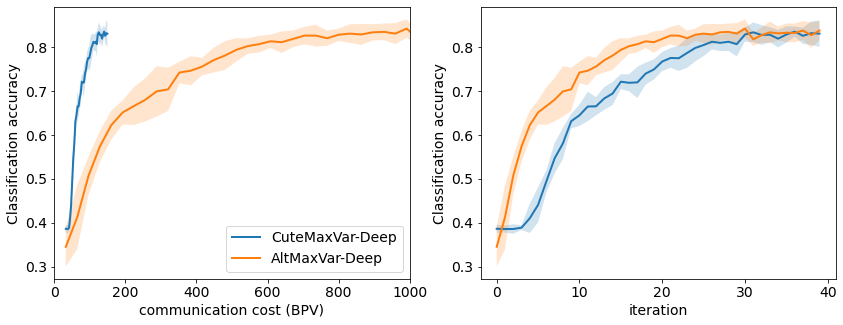

In [64]:
acc = {'cute': acc[0], 'alt': acc[1]}


fig, axes = plt.subplots(1,2, figsize=(14,5))


cute_mean = acc['cute'].mean(axis=0)
alt_mean = acc['alt'].mean(axis=0)
cute_std = acc['cute'].std(axis=0)
alt_std = acc['alt'].std(axis=0)

comm_cute = np.arange(len(cute_mean))*3 + 32
comm_alt = np.arange(len(cute_mean))*32 + 32

axes[0].plot(comm_cute, acc['cute'].mean(axis=0), linewidth=2)
axes[0].fill_between(comm_cute, cute_mean+cute_std, cute_mean-cute_std, alpha=0.2)
axes[0].plot(comm_alt, acc['alt'].mean(axis=0), linewidth=2)
axes[0].fill_between(comm_alt, alt_mean+alt_std, alt_mean-alt_std, alpha=0.2)

axes[0].legend(['CuteMaxVar-Deep', 'AltMaxVar-Deep'], fontsize=14)
axes[0].set_xlabel('communication cost (BPV)', fontsize=14)
axes[0].set_ylabel('Classification accuracy', fontsize=14)
axes[0].set_xlim(0, 1000)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)



axes[1].plot(acc['cute'].mean(axis=0), linewidth=2)
axes[1].fill_between(np.arange(len(cute_mean)), cute_mean+cute_std, cute_mean-cute_std, alpha=0.2)
axes[1].plot(acc['alt'].mean(axis=0), linewidth=2)
axes[1].fill_between(np.arange(len(alt_mean)), alt_mean+alt_std, alt_mean-alt_std, alpha=0.2)

axes[1].set_xlabel('iteration', fontsize=14)
axes[1].set_ylabel('Classification accuracy', fontsize=14)

axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

In [ ]:
acc

In [56]:
fig.savefig('../plt/class_acc_ehr_4bits_2.pdf')

In [9]:
torch.save(dgcca, 'trained_models/dgcca_ehr_diag_med_freq_dist.model')

In [66]:
for i in range(len(alt_mean)):
    if alt_mean[i] >= 0.8:
        print('alt', i)
        break
        
for i in range(len(cute_mean)):
    if cute_mean[i] >= 0.8:
        print('cute', i)
        break

alt 16
cute 25


In [53]:
alt_mean

array([0.3695, 0.437 , 0.5035, 0.583 , 0.6345, 0.6925, 0.7085, 0.7285,
       0.75  , 0.746 , 0.754 , 0.7545, 0.7745, 0.7775, 0.785 , 0.788 ,
       0.7855, 0.804 , 0.812 , 0.813 , 0.8085, 0.815 , 0.818 , 0.8205,
       0.8115, 0.8205, 0.8185, 0.8155, 0.8145, 0.821 , 0.818 , 0.808 ,
       0.799 , 0.812 , 0.8095, 0.807 , 0.8075, 0.8045, 0.8095, 0.808 ])

In [54]:
cute_mean

array([0.406 , 0.401 , 0.3985, 0.437 , 0.451 , 0.507 , 0.5485, 0.5965,
       0.669 , 0.686 , 0.7215, 0.7495, 0.7505, 0.778 , 0.794 , 0.784 ,
       0.7915, 0.798 , 0.8   , 0.7985, 0.803 , 0.822 , 0.816 , 0.828 ,
       0.816 , 0.827 , 0.827 , 0.82  , 0.8355, 0.8255, 0.826 , 0.84  ,
       0.84  , 0.835 , 0.835 , 0.834 , 0.833 , 0.831 , 0.8255, 0.8295])

In [52]:
1 - (18*4)/(17*32)

0.8676470588235294

In [29]:
alt_mean

array([0.375 , 0.371 , 0.374 , 0.379 , 0.3935, 0.4645, 0.5385, 0.604 ,
       0.6345, 0.691 , 0.7155, 0.738 , 0.7475, 0.7625, 0.7545, 0.77  ,
       0.7755, 0.8025, 0.7925, 0.804 , 0.796 , 0.806 , 0.793 , 0.8015,
       0.8125, 0.8165, 0.817 , 0.811 , 0.8165, 0.812 ])

In [30]:
cute_mean

array([0.415 , 0.409 , 0.4205, 0.4475, 0.506 , 0.6185, 0.68  , 0.7165,
       0.728 , 0.7505, 0.7625, 0.782 , 0.79  , 0.786 , 0.7865, 0.795 ,
       0.8075, 0.814 , 0.805 , 0.814 , 0.8155, 0.8115, 0.808 , 0.8005,
       0.794 , 0.8075, 0.7975, 0.801 , 0.798 , 0.805 ])

In [66]:
df_alt['class_acc']

0     0.470
1     0.620
2     0.675
3     0.645
4     0.670
5     0.715
6     0.695
7     0.725
8     0.735
9     0.745
10    0.765
11    0.780
12    0.745
13    0.775
14    0.785
15    0.760
16    0.780
17    0.790
18    0.785
19    0.785
20    0.800
21    0.820
22    0.790
23    0.770
24    0.800
25    0.790
26    0.810
27    0.795
28    0.780
29    0.790
Name: class_acc, dtype: float64

In [68]:
1- 18*3/(20*32)

0.915625

In [7]:
test_views= ehr_dataset.x[:,-args['test_size']:, :]

# dgcca.eval()
dgcca = dgcca.to('cpu')
out = dgcca(list(test_views.double()))
out = torch.stack(out)
out = out - out.mean(dim=1).unsqueeze(dim=1)
G_test = g_step(out.clone().detach())

## Plot TSNE 

Text(0.5, 1.0, 't-SNE plot of latent representation G')

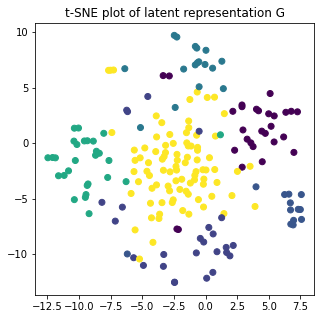

In [8]:
import numpy as np
from sklearn.manifold import TSNE

data = G_test

X = data.to('cpu').numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)

fig, axes = plt.subplots(1,1, figsize=(5,5))

sc = axes.scatter(X_embedded[:,0], X_embedded[:,1], c=ehr_dataset.y[-args['test_size']:])

axes.set_title('t-SNE plot of latent representation G')


## Classification 

In [59]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

dgcca_dist = torch.load('trained_models/dgcca_ehr_cutemaxvar1.model')
dgcca_alt = torch.load('trained_models/dgcca_ehr_altmaxvar1.model')

train_data = ehr_dataset.x[:, :-200, :]
train_views = [item.double() for item in train_data]
test_data = ehr_dataset.x[:, -200:, :]
test_views = [item.double() for item in test_data]

dgcca_dist.eval()
dgcca_dist = dgcca_dist.to('cpu')
dgcca_alt.eval()
dgcca_alt = dgcca_alt.to('cpu')

# prepare train data
out = torch.stack(dgcca_dist(train_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_train_dist = g_step(out.clone().detach())   

out = torch.stack(dgcca_alt(train_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_train_alt = g_step(out.clone().detach())  

# prepare test data
out = torch.stack(dgcca_dist(test_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_test_dist = g_step(out.clone().detach())   

out = torch.stack(dgcca_alt(test_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_test_alt = g_step(out.clone().detach())  


y_train = ehr_dataset.y[:-200]
y_test = ehr_dataset.y[-200:]

# classification for distributed method
clf_dist = svm.SVC(kernel='rbf')
clf_dist.fit(x_train_dist, y_train)

# classification for non-distributed method
clf_alt = svm.SVC(kernel='rbf')
clf_alt.fit(x_train_alt, y_train)

# classification for the raw view
clf_raw = svm.SVC(kernel='rbf')
clf_raw.fit(train_views[0], y_train)


acc_dist = accuracy_score(y_test, clf_dist.predict(x_test_dist))
acc_alt = accuracy_score(y_test, clf_alt.predict(x_test_alt))
acc_raw = accuracy_score(y_test, clf_raw.predict(test_views[0]))

acc_dist, acc_alt, acc_raw

(0.82, 0.8, 0.425)

## tsne plot (raw, gcca, alt, dist)

Text(0.5, 0, 'Classification Acc. 80.0 %')

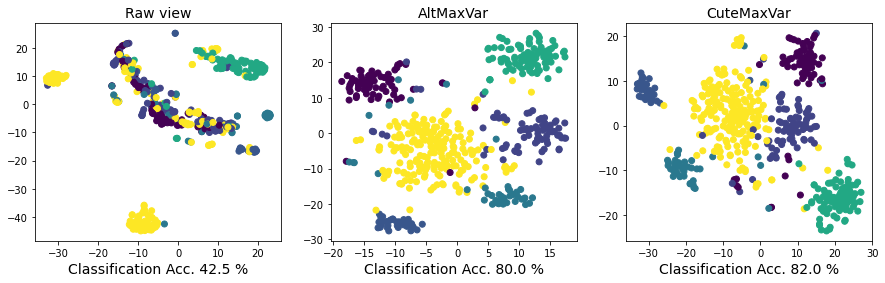

In [69]:
import numpy as np
from sklearn.manifold import TSNE

dgcca_dist = torch.load('trained_models/dgcca_ehr_cutemaxvar1.model')
dgcca_alt = torch.load('trained_models/dgcca_ehr_altmaxvar1.model')

test_size = 500

train_data = ehr_dataset.x[:, :-test_size, :]
train_views = [item.double() for item in train_data]
test_data = ehr_dataset.x[:, -test_size:, :]
test_views = [item.double() for item in test_data]

dgcca_dist.eval()
dgcca_dist = dgcca_dist.to('cpu')
dgcca_alt.eval()
dgcca_alt = dgcca_alt.to('cpu')

# prepare train data
out = torch.stack(dgcca_dist(train_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_train_dist = g_step(out.clone().detach())   

out = torch.stack(dgcca_alt(train_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_train_alt = g_step(out.clone().detach())  

# prepare test data
out = torch.stack(dgcca_dist(test_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_test_dist = g_step(out.clone().detach())   

out = torch.stack(dgcca_alt(test_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_test_alt = g_step(out.clone().detach())  

y_train = ehr_dataset.y[:-test_size]
y_test = ehr_dataset.y[-test_size:]


# Tsne embeddings

x_embedded_raw = test_views[0].to('cpu').numpy()
x_embedded_raw = TSNE(n_components=2).fit_transform(x_embedded_raw)


x_embedded_dist = x_test_dist.to('cpu').numpy()
x_embedded_dist = TSNE(n_components=2).fit_transform(x_embedded_dist)

x_embedded_alt = x_test_alt.to('cpu').numpy()
x_embedded_alt = TSNE(n_components=2).fit_transform(x_embedded_alt)


fig, axes = plt.subplots(1,3, figsize=(15, 4))

axes[0].scatter(x_embedded_raw[:,0], x_embedded_raw[:,1], c=y_test)
axes[0].set_title('Raw view', fontsize=14)
axes[0].set_xlabel('Classification Acc. 42.5 %', fontsize=14)

axes[2].scatter(x_embedded_dist[:,0], x_embedded_dist[:,1], c=y_test)
axes[2].set_title('CuteMaxVar', fontsize=14)
axes[2].set_xlabel('Classification Acc. 82.0 %', fontsize=14)


axes[1].scatter(x_embedded_alt[:,0], x_embedded_alt[:,1], c=y_test)
axes[1].set_title('AltMaxVar', fontsize=14)
axes[1].set_xlabel('Classification Acc. 80.0 %', fontsize=14)



# axes.set_title('t-SNE plot of latent representation G')

In [64]:
G.shape

torch.Size([527, 20])

In [70]:
fig.savefig('../plt/ehr_dataset_tsne_plot.pdf')

torch.Size([527, 20])

Text(0.5, 1.0, 't-SNE plot of latent representation G')

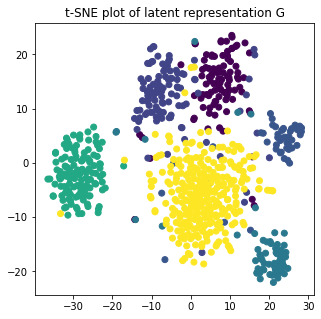

In [4]:
# Plot t-sne for only those classes for which the number of data points exceed min_entities 
# and corresponds to a clearly separable classes 
# one of the diagnosis is just e.g. we have Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified 

min_entities = 40

# sort x and y according to class index
a = np.argsort(ehr_dataset.y)
y = ehr_dataset.y[a]
x = G[a,:]

num_ind = []
idx = {y[0].item():1}
j = y[0]
sumid = 0

# count all the indices
for i in y:
    if not j==i:
        j = i
        idx[j.item()] = 1
        num_ind.append(sumid)
        sumid = 0
    else:
        idx[i.item()] += 1

# get the most frequent classes
frequent_keys = []
for key in idx:
    if idx[key] >= min_entities:
        frequent_keys.append(key)

# remove the entities related to SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS (780-799)
freq_id = []
for i in range(len(y)):
    if y[i] in frequent_keys:
        if not y[i] == frequent_keys[5]:
            freq_id.append(i)
            
# get the truccated representation
y_trunc = y[freq_id]
x_trunc = x[freq_id]

import numpy as np
from sklearn.manifold import TSNE

X = x_trunc.to('cpu').numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)

fig, axes = plt.subplots(1,1, figsize=(5,5))

sc = axes.scatter(X_embedded[:,0], X_embedded[:,1], c=y_trunc)

axes.set_title('t-SNE plot of latent representation G')

torch.Size([20])

In [8]:
y_trunc

tensor([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7, 

In [3]:
from dgcca.ehr.dataset_ehr import *

ehr_dataset = EhrDataset(data_file='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_med_1045',
                         shuffle=True)


freq_id, freq_classes = get_frequent_indices(ehr_dataset.y, min_count=40, except_classes=[15])

ehr_dataset.y[freq_id]

tensor([ 3, 12,  6, 18,  7, 12, 18, 12,  7,  9,  9, 18,  9,  3,  6, 18,  6, 12,
        18, 12, 18,  6, 12, 18, 18, 18, 18,  7, 18,  6, 18, 18, 18, 18, 12, 12,
         6, 12, 12,  3,  3, 12, 12,  3, 18, 12, 12,  7,  6,  7,  6,  9,  6, 18,
         9, 18,  3, 18,  7, 12, 18, 18,  6, 12,  6,  9, 18,  9, 12,  3, 18, 12,
         9, 18, 18,  6,  6, 12,  7, 18,  9, 18,  6, 18,  3, 18,  3, 18,  3, 18,
        18,  6,  6,  9,  9,  9,  3,  3, 18, 12,  7, 12, 18,  3, 18, 18, 18,  7,
        18, 18,  6, 18, 18,  3,  3,  3, 18, 18, 12, 12,  6, 18, 18, 18, 18,  7,
         9,  6, 12, 12, 18, 18,  9,  6,  3,  7, 12, 18,  3, 12,  3, 12,  7,  3,
        18,  3, 18, 18, 12,  3, 18,  6, 12,  9, 12,  9, 12, 18, 18, 18,  3,  6,
         9,  3,  3,  3, 12,  6, 18, 18,  7, 18,  7,  3,  6, 18,  6, 12,  6, 18,
        12,  6, 12, 18, 18, 12,  6,  6, 18, 12, 18, 18,  3,  7,  6, 18,  9,  3,
        18,  3, 18,  9,  6, 18,  6, 12,  3,  9,  7, 12, 18, 18, 12,  3, 18, 18,
         9, 18,  6, 12,  6,  9, 18,  3, 

In [5]:
torch.save((list(ehr_dataset.x[:,freq_id,:]), ehr_dataset.y[freq_id]), '/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_med_frequent')

In [16]:
y_trunc

tensor([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7, 

In [13]:
frequent_keys

[3, 6, 7, 9, 12, 15, 18]

In [12]:
frequent_keys

[3, 6, 7, 9, 12, 15, 18]

In [5]:
ehr_dataset

In [138]:
frequent_keys[5]

15

In [ ]:

fig, axes = plt.subplots(1,1, figsize=(5,5))

sc = axes.scatter(X_embedded[:,0], X_embedded[:,1], c=y_trunc)

axes.set_title('t-SNE plot of latent representation G')

In [131]:
frequent_keys 

[3, 6, 7, 9, 12, 15, 18]

In [123]:
x_trunc.shape

torch.Size([3, 861, 511])

## Run autoencoder architecture based DGCCA on EHR dataset

In [122]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from dgcca.utils.run_manager import RunBuilder
from dgcca.models import g_step, AE_DGCCA, AELinear
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import argparse
import pprint as pp
from dgcca.ehr.dataset_ehr import *
from dgcca.utils.qsgd import qsgd


if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest',
                    default='trained_models/dgcca_ehr_diag_med_ae_1.model', 
                    help="Destination model path")
parser.add_argument('--random_seed', default=4328, help='')

args = vars(parser.parse_args(args = []))
pp.pprint(args)

# Set the random seed
torch.manual_seed(int(args['random_seed']))

params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    quant = [False],
    latent_dim = [20], 
    num_inner_epochs = [10],
    rand_compress=[True], 
    n_bits=[4]
)

ehr_dataset = EhrDataset(data_file='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_med_1045',
                         shuffle=True)
mat = x_trunc.shape

run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = AE_DGCCA(num_views=len(mat), 
                     input_size=mat[0].shape[-1],
                     output_size=run.latent_dim,
                     network=AELinear,
                     use_relu=True,
                     use_batch_norm=True)
    dgcca = dgcca.to('cpu')
    
    train_views = [item.to('cpu') for item in mat]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    criterion = run.loss_func()

    out = torch.stack(dgcca(train_views))
    G = g_step(out.clone().detach())  
    G_serv = G.clone()
    M_serv = out.detach().clone()
    
    I = len(train_views)
    
    for epoch in trange(250):
        total_recons_loss = 0
        batch_count = 0
        total_dgcca_loss = 0
        
        dgcca.to('cuda')
        
        for _ in range(run.num_inner_epochs):

            optimizer.zero_grad()
            batch = []

            # full gradient
            batch = [item.to(device) for item in train_views]
            target = G.to(device)
            
            latent = dgcca(batch)

            ae_loss = 100*(run.latent_dim/(2*511*target.shape[0]))*torch.norm(torch.stack(dgcca.decode(latent)) - torch.stack(batch))

            dgcca_loss = 1/2*torch.norm(torch.stack(latent)-target)/target.shape[0] 

            loss = dgcca_loss #+ ae_loss

            loss.backward()

            optimizer.step()

            total_recons_loss += ae_loss.item()
            total_dgcca_loss += dgcca_loss.item()
            del batch, target, latent

        dgcca.to('cpu')
        out = torch.stack(dgcca(train_views)).detach().clone()        
        if run.quant:
            for i in range(I):
                diff = out[i] - M_serv[i]
                max_val = diff.abs().max()
                if run.rand_compress:
                    quant = qsgd(diff, n_bits=run.n_bits)
                else:
                    quant = ((1/max_val)*diff).round()*(max_val/1)    
                var = M_serv[i] + quant
                M_serv[i] = var
                M_serv[i] -= M_serv[i].mean(dim=0)
                del max_val, diff, quant, var
            G = g_step(M_serv.clone().detach())
            G_serv = G_serv + qsgd(G-G_serv)
        else:
            out = out- out.mean(dim=1).unsqueeze(dim=1)
            G = g_step(out.clone().detach())   
        del out
        dgcca.train()
        
        
        results = OrderedDict()
        results['epoch'] = epoch
        results['recons_loss'] = total_recons_loss/(run.num_inner_epochs)
        results['dgcca_loss'] = total_dgcca_loss/(run.num_inner_epochs)
        results['lr'] = run.lr

        run_data.append(results)
        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
        display(df3)

        torch.save(dgcca, args['model_dest'])
        

,epoch,recons_loss,dgcca_loss,lr
0,0,204.608156,0.017482,0.001
1,1,204.612822,0.004131,0.001
2,2,204.610789,0.003152,0.001
3,3,204.614610,0.002865,0.001
4,4,204.610524,0.002705,0.001
...,...,...,...,...
245,245,204.613046,0.000429,0.001
246,246,204.614098,0.000429,0.001
247,247,204.611873,0.000431,0.001
248,248,204.613463,0.000429,0.001


100%|██████████| 250/250 [00:42<00:00,  5.89it/s]


In [111]:
mat.shape

torch.Size([3, 861, 511])

In [101]:
out

NameError: name 'out' is not defined

In [91]:
mat[0].max()

tensor(23808.)

In [93]:
mat[0].mean()

tensor(7.1794)

In [96]:
mat[2].max()

tensor(23908.)

## Clustering Acc

In [5]:
# Latent Representation
from dgcca.utils.clustering import *

def get_clustering_acc(n_clusters=10, gamma=5, random_state=150, latent_repr = None, test_classes=None):
    assert latent_repr is not None
    pred = SpectralClustering(n_clusters=n_clusters, gamma=gamma, random_state=random_state).fit_predict(latent_repr)

    cluster_map = cluster_permutation_map(pred, test_classes.numpy())
    mapped_labels = map(pred, cluster_map)
    acc = delta_sum(mapped_labels, test_classes[:3000].numpy())/ len(pred)
    return acc


In [147]:
get_clustering_acc(n_clusters=6, latent_repr=x_trunc, test_classes=y_trunc)

0.3947730398899587

In [142]:
y_trunc

tensor([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7, 

In [2]:
from dgcca.ehr.dataset_ehr import *
ehr_dataset = EhrDataset(data_file='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_med_1045',
                         shuffle=True)
all_data = list(ehr_dataset.x)
mat = ehr_dataset.x

In [3]:
mat[0].shape

torch.Size([1045, 511])

In [56]:
def get_diagnosis_classes_list_from_dict(filename=None, data=None):
    """
    Get CMS classes from the ordered dictionary with keys as tuple of (diagnosis, category2)
    returns a list of classes index
    """
    if filename is not None:
        _, data = torch.load(filename)

    if isinstance(data, list):
        data = data[0]
    
    classes = []
    cl_list = ((100, 139), 
            (140, 239), 
            (240, 289),
            (290, 319),
            (320, 389),
            (390, 459), 
            (460, 519),
            (520, 579),
            (580, 629),
            (630, 679),
            (680, 709),
            (710, 739),
            (740, 759),
            (760, 779),
            (780, 799),
            (800, 999))

    keys = list(data.keys())
    num_rows = data[keys[-1]][0]+1
    num_cols = data[keys[-1]][1]+1
    classes = [0]*num_rows
    for i in range(num_rows):
        if keys[i*num_cols][0].startswith('0'):
            classes[i] = 1
        elif keys[i*num_cols][0].startswith('E'):
            classes[i] = 17
        elif keys[i*num_cols][0].startswith('V'):
            classes[i] = 18
        else:
            num = int(keys[i*num_cols][0][:3])
            for j in range(len(cl_list)):
                if num >= cl_list[j][0] and num <= cl_list[j][1]:
                    classes[i] = j+1
    return classes

classes = get_diagnosis_classes_list_from_dict(filename='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/dictionary_data/combined_views')

In [13]:
torch.save((mat, classes), "/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_pr_520")

In [38]:
def redefine_features(filename=None):
    """
    Get CMS classes from the ordered dictionary with keys as tuple of (diagnosis, category2)
    returns a list of classes index
    """
    filename='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/dictionary_data/combined_views'
    mat, data = torch.load(filename)
    num_classes = 18
    new_mat = torch.zeros(len(mat), mat[0].shape[0], num_classes)
    if isinstance(data, list):
        data = data[0]

    classes = []
    cl_list = ((100, 139), 
            (140, 239), 
            (240, 289),
            (290, 319),
            (320, 389),
            (390, 459), 
            (460, 519),
            (520, 579),
            (580, 629),
            (630, 679),
            (680, 709),
            (710, 739),
            (740, 759),
            (760, 779),
            (780, 799),
            (800, 999))

    keys = list(data.keys())
    num_rows = data[keys[-1]][0]+1
    num_cols = data[keys[-1]][1]+1
    classes = [[] for i in range(num_classes)]
    #     classes = [0]*num_rows

    for i in range(num_cols):

        if keys[i][1].startswith('0'):
            classes[0].append(i)
        elif keys[i][1].startswith('E'):
            classes[16].append(i)
        elif keys[i][1].startswith('V'):
            classes[17].append(i)
        else:
            num = int(keys[i][1][:3])
            for j in range(len(cl_list)):
                if num >= cl_list[j][0] and num <= cl_list[j][1]:
                    classes[j].append(i)
    for view in range(len(mat)):
        for cl in range(num_classes):
            new_mat[view,:,cl] = mat[view][:,classes[cl]].sum(dim=-1)

    return new_mat

new_mat = redefine_features(filename='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/dictionary_data/combined_views')